### **<span style="color: purple; ">・概要</span>**

<pre>
最終更新日: 2023/7/15

試作自動取引BOT サンプルコードです。
現在までで色んな物を作ってみましたがその中の一つとして、
現コーディングスキルをご確認頂く目的でまとめた物になります。
細かい設定箇所（ログイン情報等）、戦略（売買フラグ等）、その他一部非公開部分があります。

このプログラムはrnn（gru）を使用し、数分後の価格を予測、各種インジケーターを計算、
その中から戦略に使用し売買の判断をさせると言ったイメージになります。

●プログラムの流れ
・MetaTrader5 APIによりリアルタイムで50000サンプルを取得
・一旦各種インジケーターを計算し、相関係数を計算
・相関係数から使用する説明変数を選択
（多重境界線の問題もありますが、ほとんどが0.9超えのため使えそうな物をチョイス。
  kernel_regularizerやbatch normalizationを使用すると精度が悪化するので今回は不使用。
  過学習の懸念があるため出来る限り次元数は少なめにしました。）
・学習を行ったモデルを使用しテスト、2バー分（5分足バー 2個分）で未来予測
・予測した未来の値を含めてインジケーター類を再計算
・出来上がったデータを使用し戦略通りに売買フラグを判定、売買やtpslの再設定、クローズ処理、何もしない等を自動で処理
・合わせて各インジケーター類をグラフで出力

●備考
・性質的な物として外れ値除外は行っていません。（一度Hampel Identifier σ±2で試した所精度が下がったのもあります。）
・今回は正規化（MinMaxScaler）を使用しています。標準化（StandardScaler）は精度が下がるので使用していません。
・主成分分析（PCA）もあまり効果が得られなかったため不使用です。
・hparamの一部が半端な数値になっていますが、optunaでgrid serch的な事を行った物を使用したためです。
・本来onlstmを使用したかったのですが、MetaTrader5のnumpy対応バージョンの関係で使用出来なかったためgruにしました。
・このプログラムでは単純な価格予測（regression）を行っていますが、
　lightgbmでのトレンドフラグ予測（multi class classification）も試しました。
　コードにつきましてはmt5_model_functions.pyの最後の方になります。
・自然言語処理を組み込み経済指標データも使うと精度向上に繋がりそうです。
</pre>

### **<span style="color: purple; ">・import</span>**

In [1]:

#-- デバッグ時に使用。自作クラス、関数をリロード。必要に応じてコピーして使用
'''
import self_create.mt5_settings_functions
reload(self_create.mt5_settings_functions)
from self_create.mt5_settings_functions import * 
import self_create.mt5_main_functions
reload(self_create.mt5_main_functions)
from self_create.mt5_main_functions import * 
import self_create.mt5_model_functions
reload(self_create.mt5_model_functions)
from self_create.mt5_model_functions import * 
'''
####################################################################################################

from self_create.mt5_settings_functions import * 
from self_create.mt5_main_functions import * 
from self_create.mt5_model_functions import * 

import MetaTrader5 as mt5

import pandas as pd
import numpy as np
from time import time, sleep
from datetime import datetime, timezone, timedelta
from copy import copy, deepcopy

import traceback
import math
import itertools
import random
import json

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import japanize_matplotlib
import seaborn as sns

from importlib import reload

import lightgbm as lgb

from keras.models import model_from_json
from keras.utils import custom_object_scope
from tensorflow.keras.utils import get_custom_objects

pd.options.display.float_format = '{:.5f}'.format

display("import completed")


'import completed'

### **<span style="color: purple; ">・MetaTrader 起動</span>**

In [2]:

trade_mode = 0 # 検証用モード
#trade_mode = 1 # 本番用モード
received_use_data = data_of_pass_to_body_def(trade_mode)

login_ID = received_use_data["account_login"]["login_ID"]
login_server = received_use_data["account_login"]["login_server"]
login_password = received_use_data["account_login"]["login_password"]

###############################

#-- MT5 ログイン
if not mt5.initialize(login=login_ID, server=login_server,password=login_password):
    print("initialize() failed, error code =",mt5.last_error())
    quit()

#-- 接続ができたらMT5のバージョンを表示する
print(f"MetaTrader5 package version {mt5.__version__}")


MetaTrader5 package version 5.0.45


### **<span style="color: purple; ">・設定類</span>**

In [3]:
#-- 非公開ファイルの中身ですが、各設定項目をロード

received_use_data = data_of_pass_to_body_def(trade_mode)

future_period = received_use_data["model_relations"]["future_period"]
freq_num = received_use_data["model_relations"]["freq_num"]
freq = received_use_data["model_relations"]["freq"]
target_model_path = received_use_data["model_relations"]["target_model_path"]

###############################

rnn_batch_size = received_use_data["model_relations"]["rnn_batch_size"]
test_rate = received_use_data["model_relations"]["test_rate"]
train_rate = received_use_data["model_relations"]["train_rate"]

outlier_handling_use = received_use_data["model_relations"]["outlier_handling_use"]
multiplier = received_use_data["model_relations"]["multiplier"]

select_mode = received_use_data["model_relations"]["select_mode"]
dim_quantity = received_use_data["model_relations"]["dim_quantity"]

variable_delete_rate_min = received_use_data["model_relations"]["variable_delete_rate_min"]
variable_delete_rate_max = received_use_data["model_relations"]["variable_delete_rate_max"]

####################################################################################################

first_lot = received_use_data["mt5_setting_relations"]["first_lot"]
magic_number = received_use_data["mt5_setting_relations"]["magic_number"]
slippage = received_use_data["mt5_setting_relations"]["slippage"]
spread_tolerance = received_use_data["mt5_setting_relations"]["spread_tolerance"]
set_margin_level = received_use_data["mt5_setting_relations"]["set_margin_level"]

time_frame = received_use_data["mt5_setting_relations"]["time_frame"]
data_back_pos = received_use_data["mt5_setting_relations"]["data_back_pos"]

bar_period = received_use_data["mt5_setting_relations"]["bar_period"]
order_cancel_period = received_use_data["mt5_setting_relations"]["order_cancel_period"]
calc_use_num = received_use_data["mt5_setting_relations"]["calc_use_num"]

trade_wait_time = received_use_data["mt5_setting_relations"]["trade_wait_time"]
graph_wait_time = received_use_data["mt5_setting_relations"]["graph_wait_time"]
trade_stop_flag = received_use_data["mt5_setting_relations"]["trade_stop_flag"]
    
graph_time_range = received_use_data["mt5_setting_relations"]["graph_time_range"]
graph_set_time_start = received_use_data["mt5_setting_relations"]["graph_set_time_start"]
graph_set_time_end = received_use_data["mt5_setting_relations"]["graph_set_time_end"]

symbol_list = received_use_data["mt5_setting_relations"]["symbol_list"]
f2_group = received_use_data["mt5_setting_relations"]["f2_group"]
f3_group = received_use_data["mt5_setting_relations"]["f3_group"]
f5_group = received_use_data["mt5_setting_relations"]["f5_group"]

####################################################################################################

price_range_storage = {}
for symbol in symbol_list:
    price_range_storage[symbol] = {"bollinger_spread_range": [], "low_under_line": None, "high_under_line": None, "atr": [], "atr_under_line": None}
####################################################################################################

#-- 東京市場用
trade_start_time_tk, trade_end_time_tk = get_trade_start_end_time("tk")

#-- ロンドン市場用
trade_start_time_ld, trade_end_time_ld = get_trade_start_end_time("ld")

#-- ニューヨーク市場用
trade_start_time_ny, trade_end_time_ny = get_trade_start_end_time("ny")

####################################################################################################

start_time = datetime.now() + timedelta(minutes=-1)
start_time = datetime.strptime("{0:%Y-%m-%d %H:%M:%S}".format(start_time), '%Y-%m-%d %H:%M:%S')
last_trade_time = start_time

last_graph_render_time_dic = {}
for name in symbol_list:
    last_graph_render_time_dic["symbol"] = name
    last_graph_render_time_dic[name] = start_time


### **<span style="color: purple; ">・周期性有無の確認</span>**

●周期性確認

・15分単位


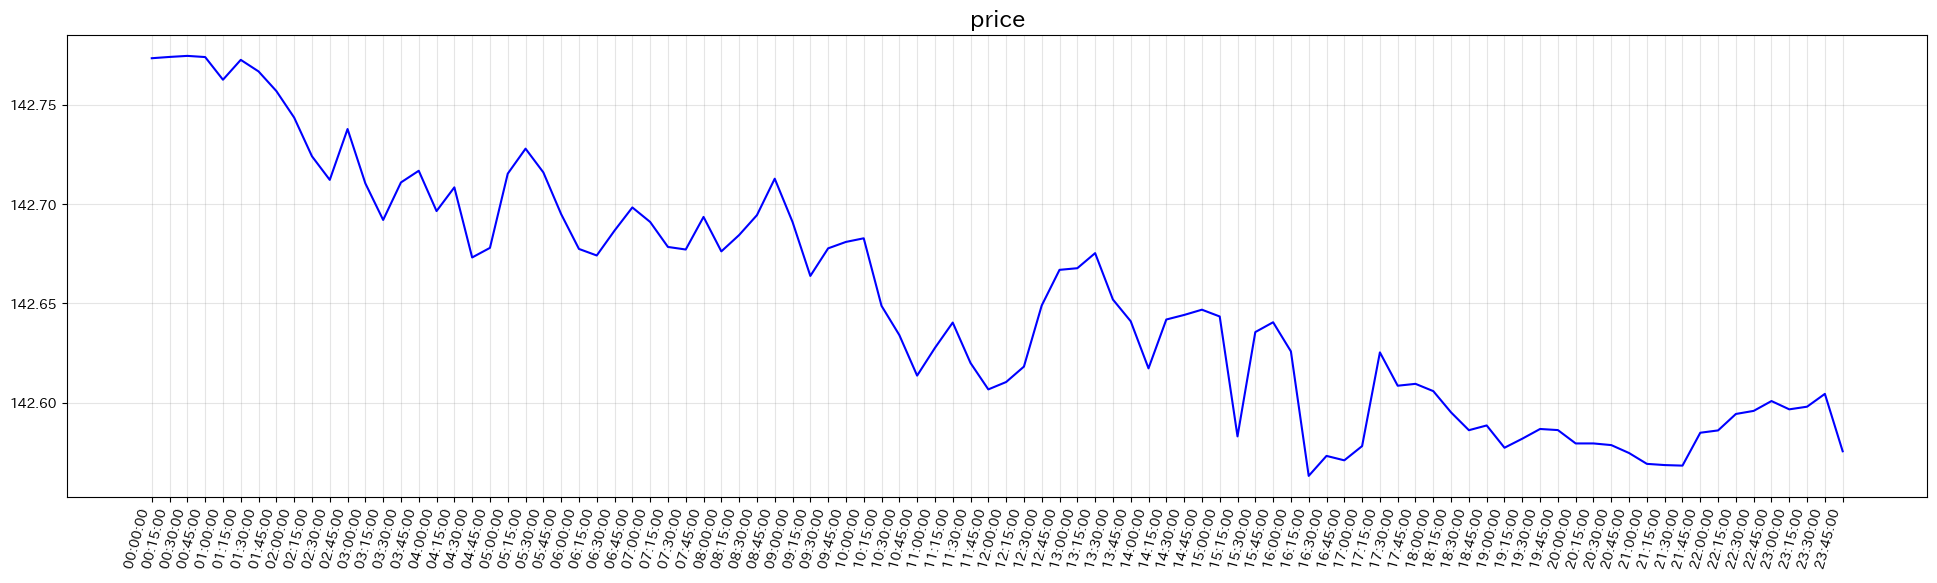

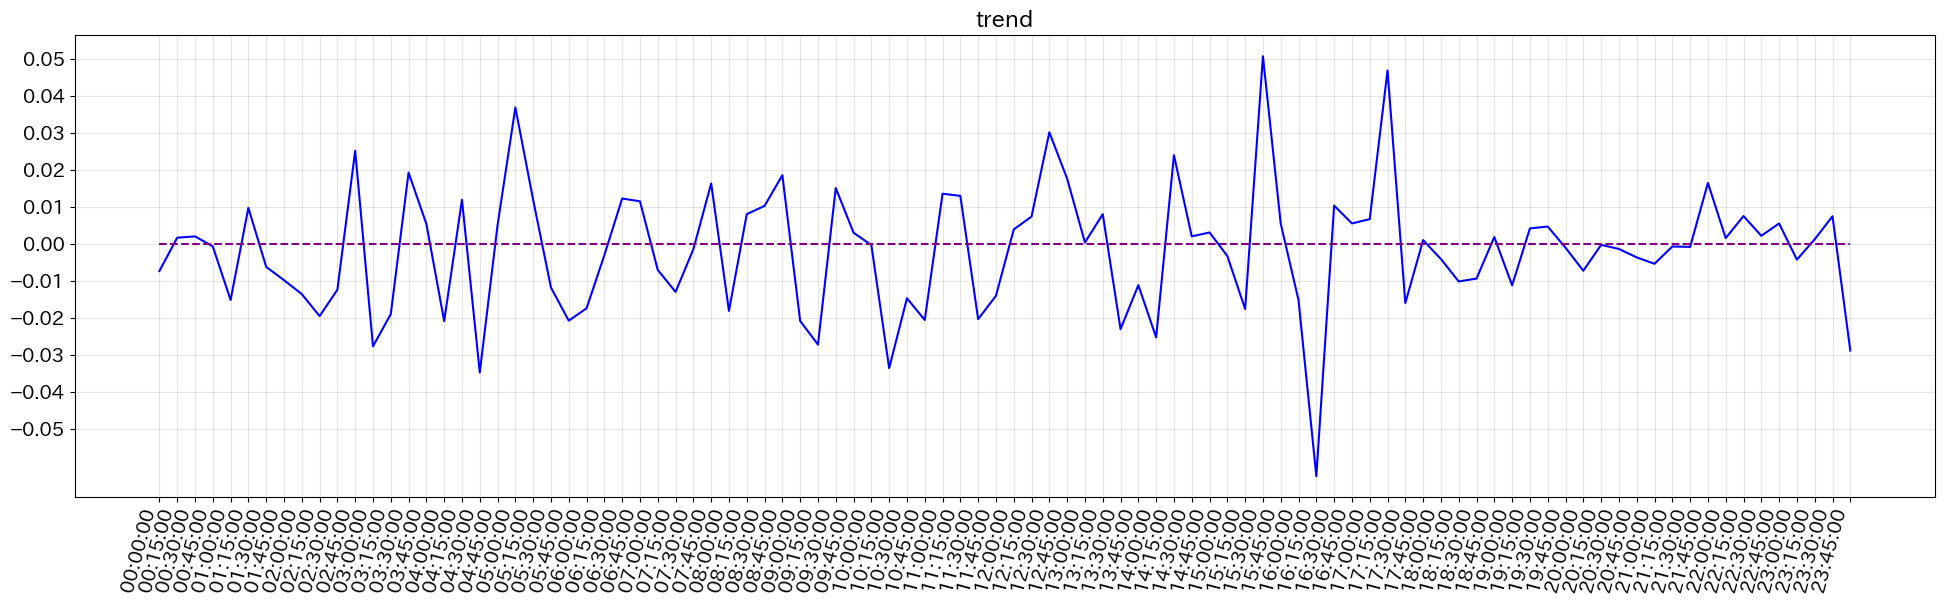


・30分単位


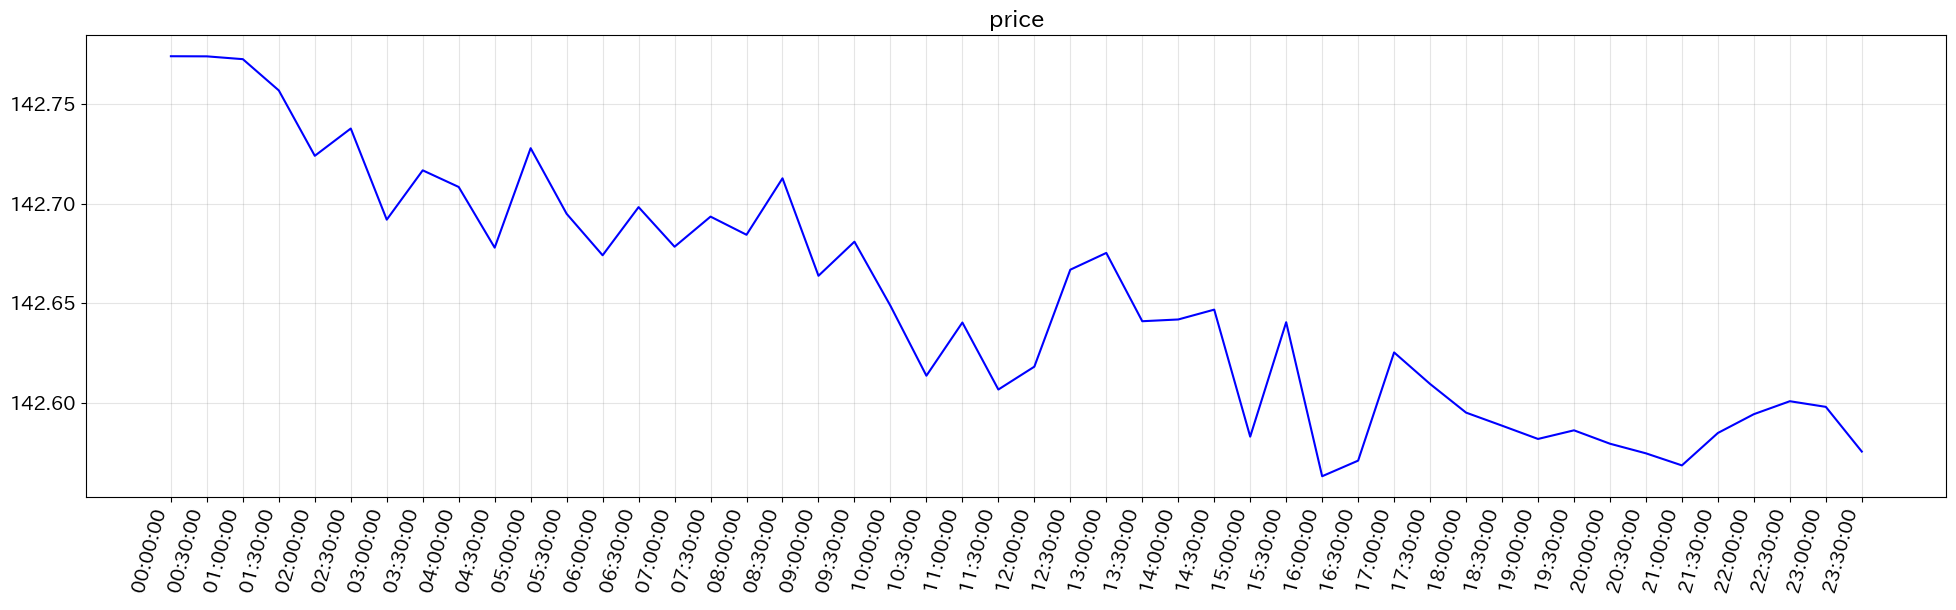

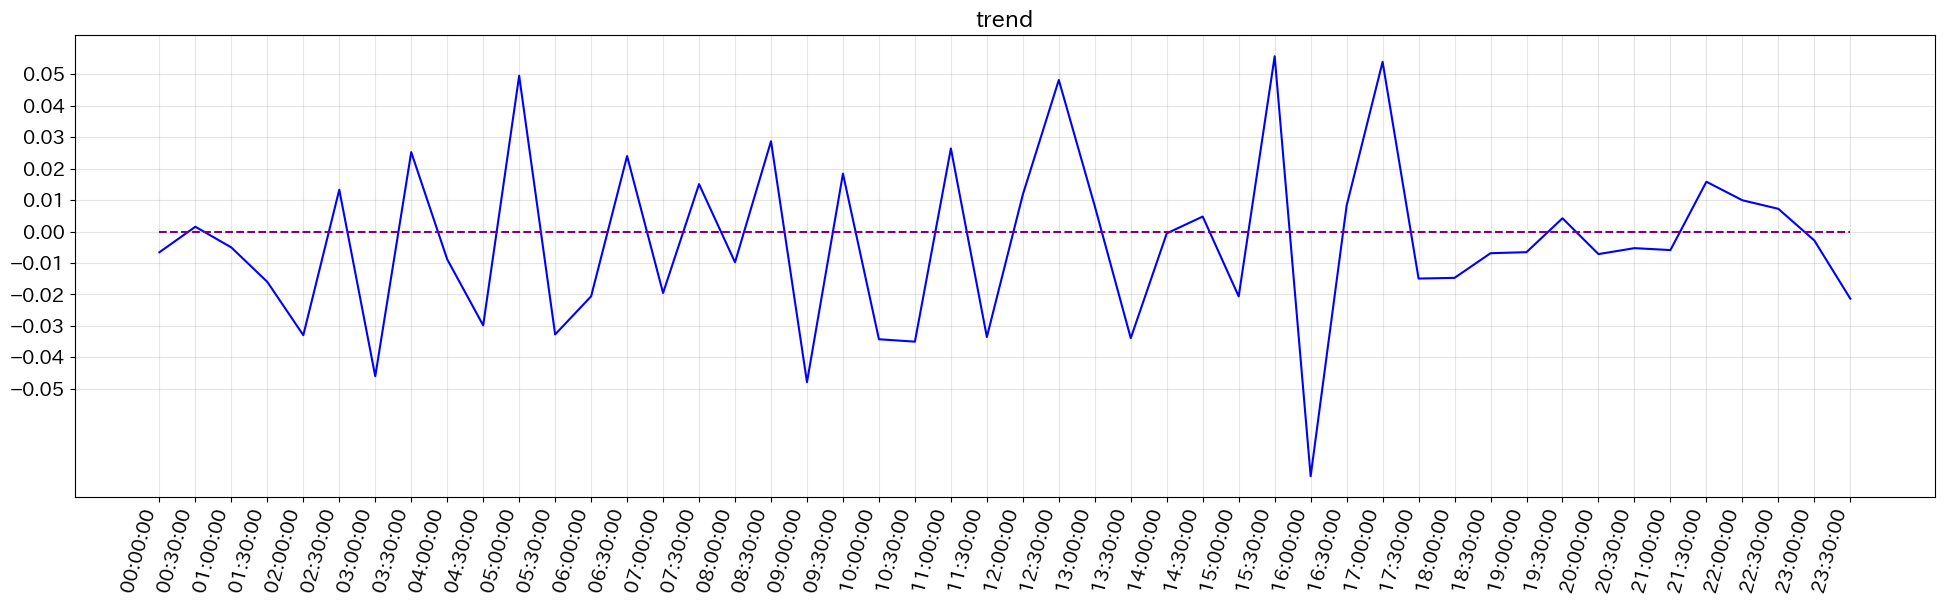


・1時間単位


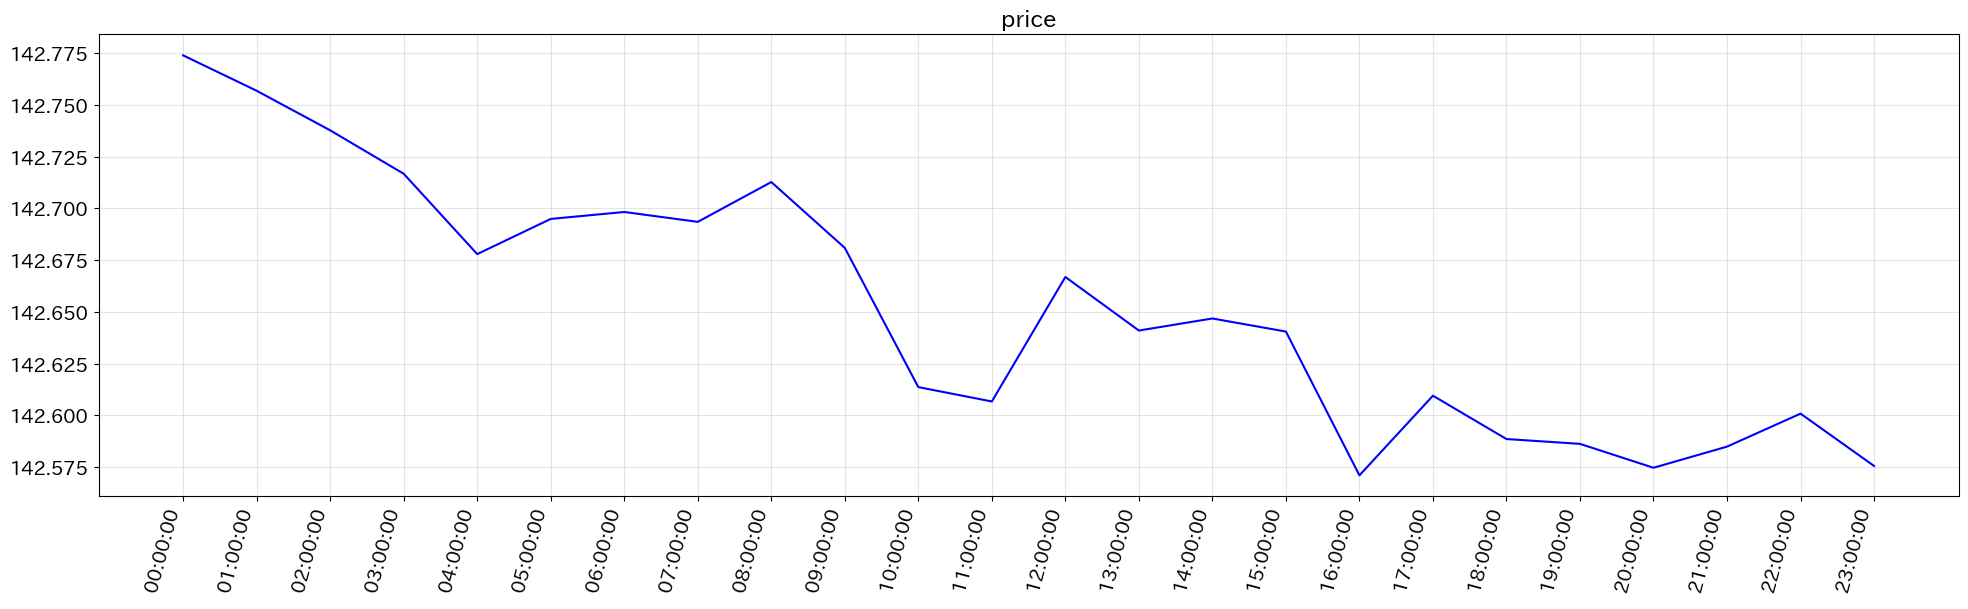

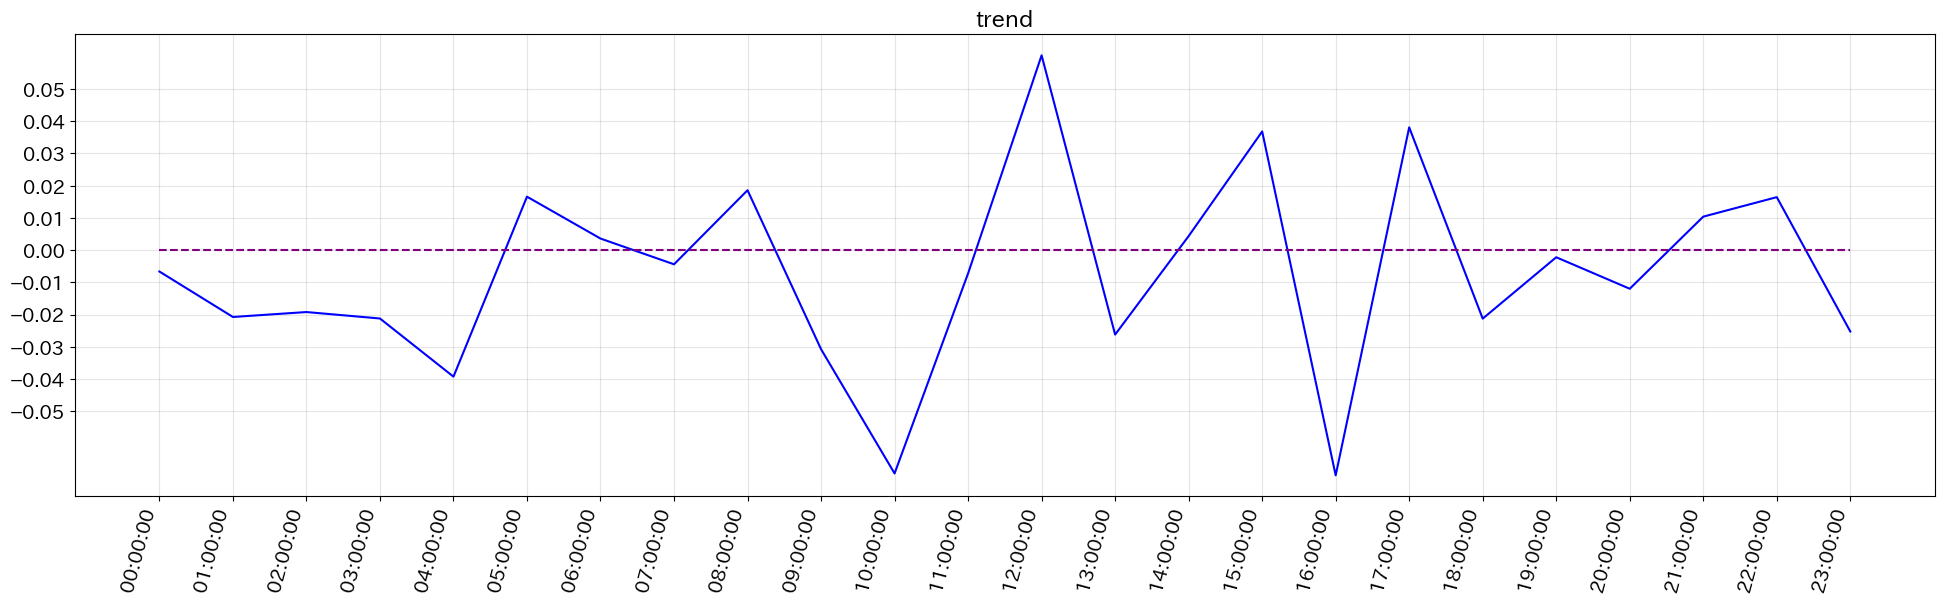


・1日単位


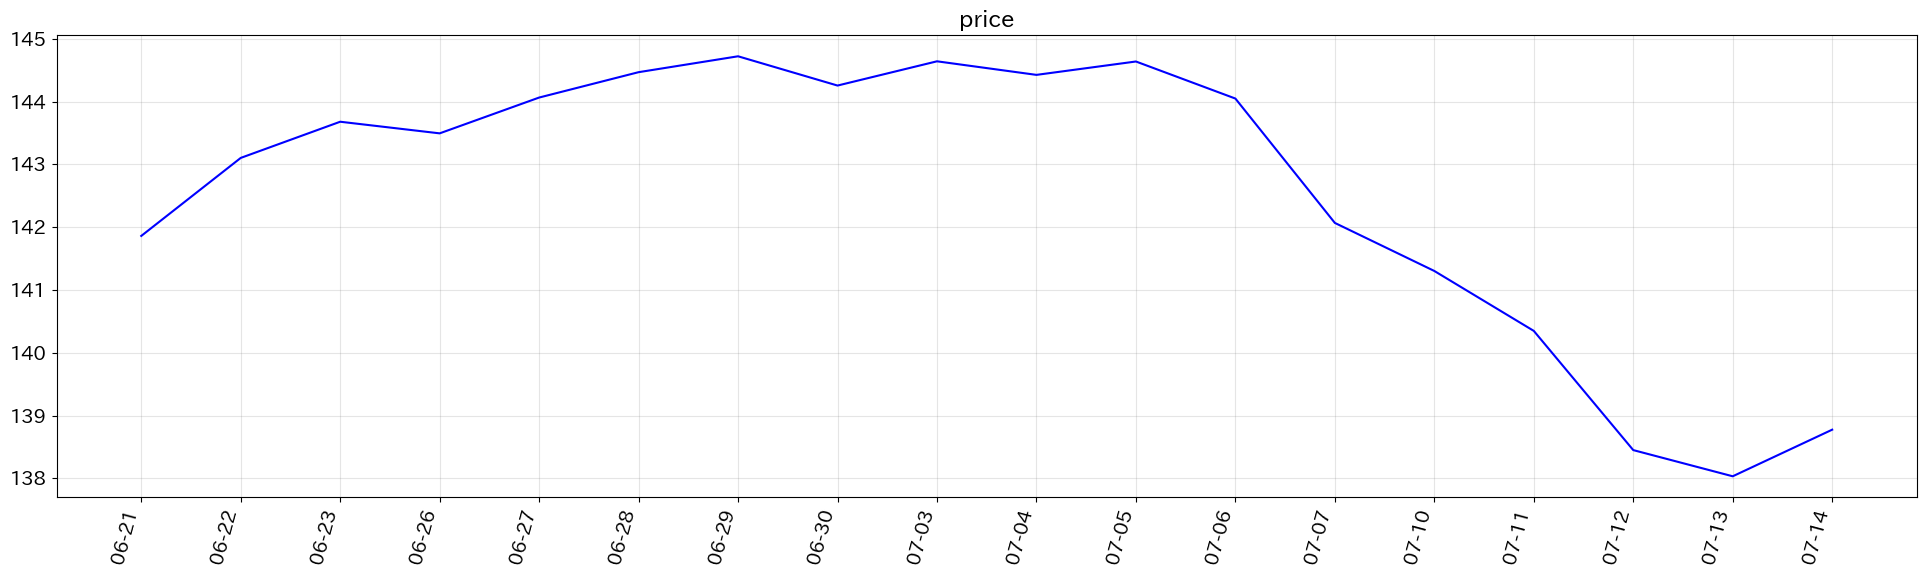

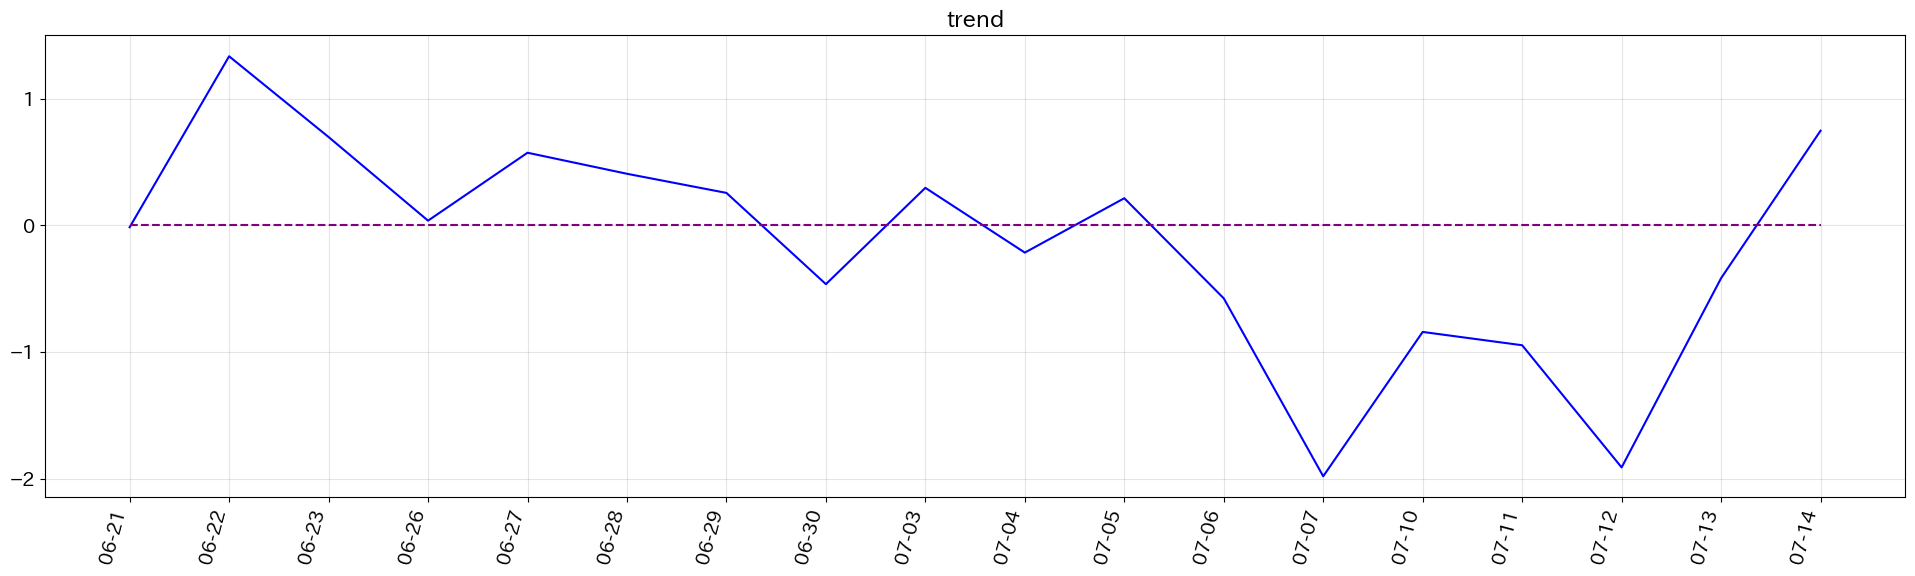


・曜日単位


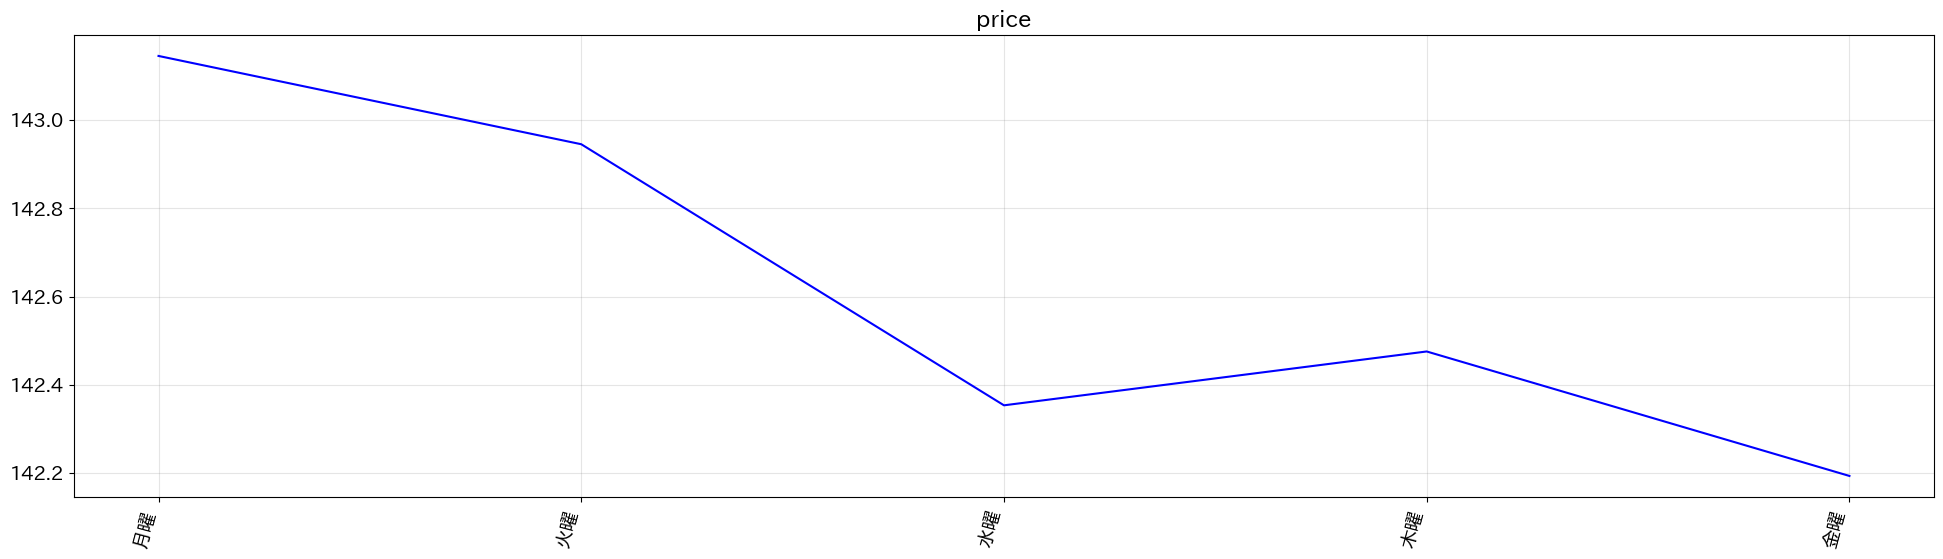

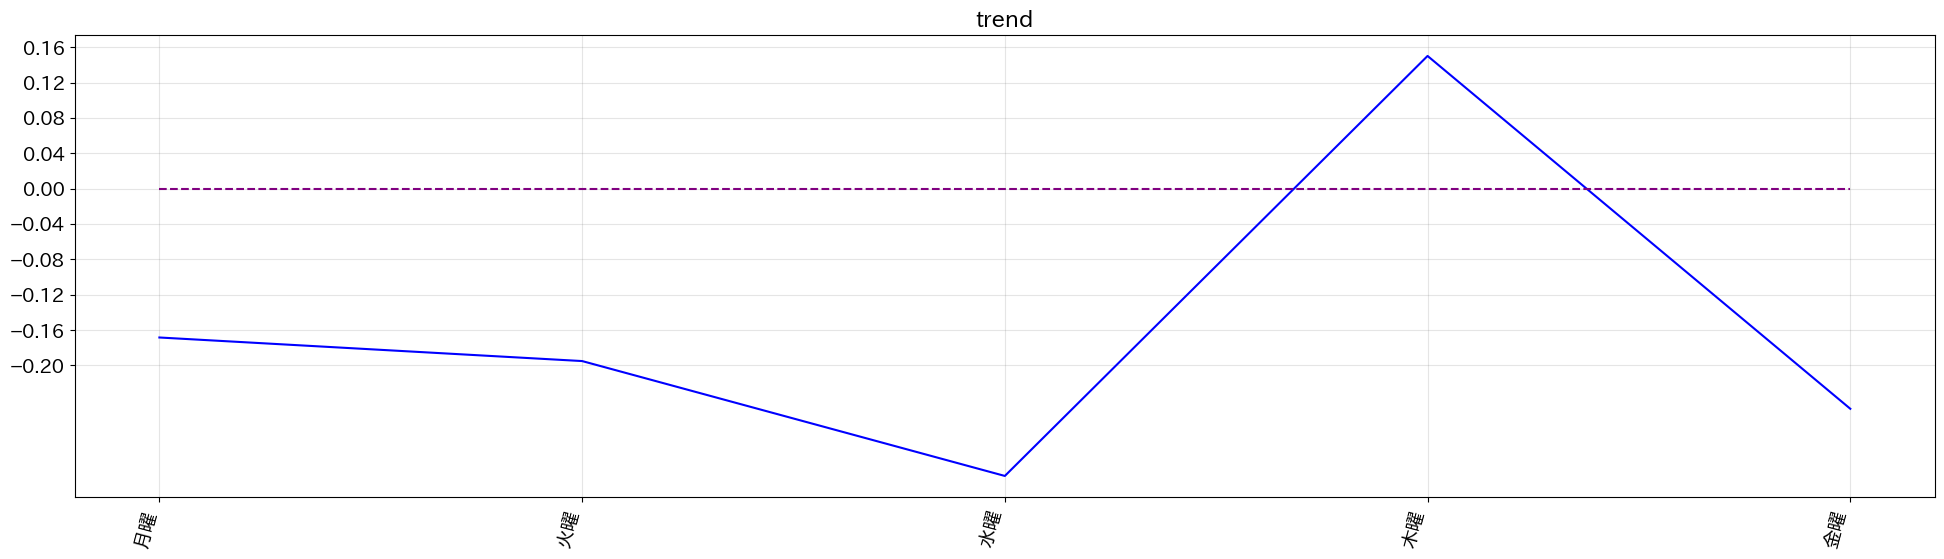


・第何週単位


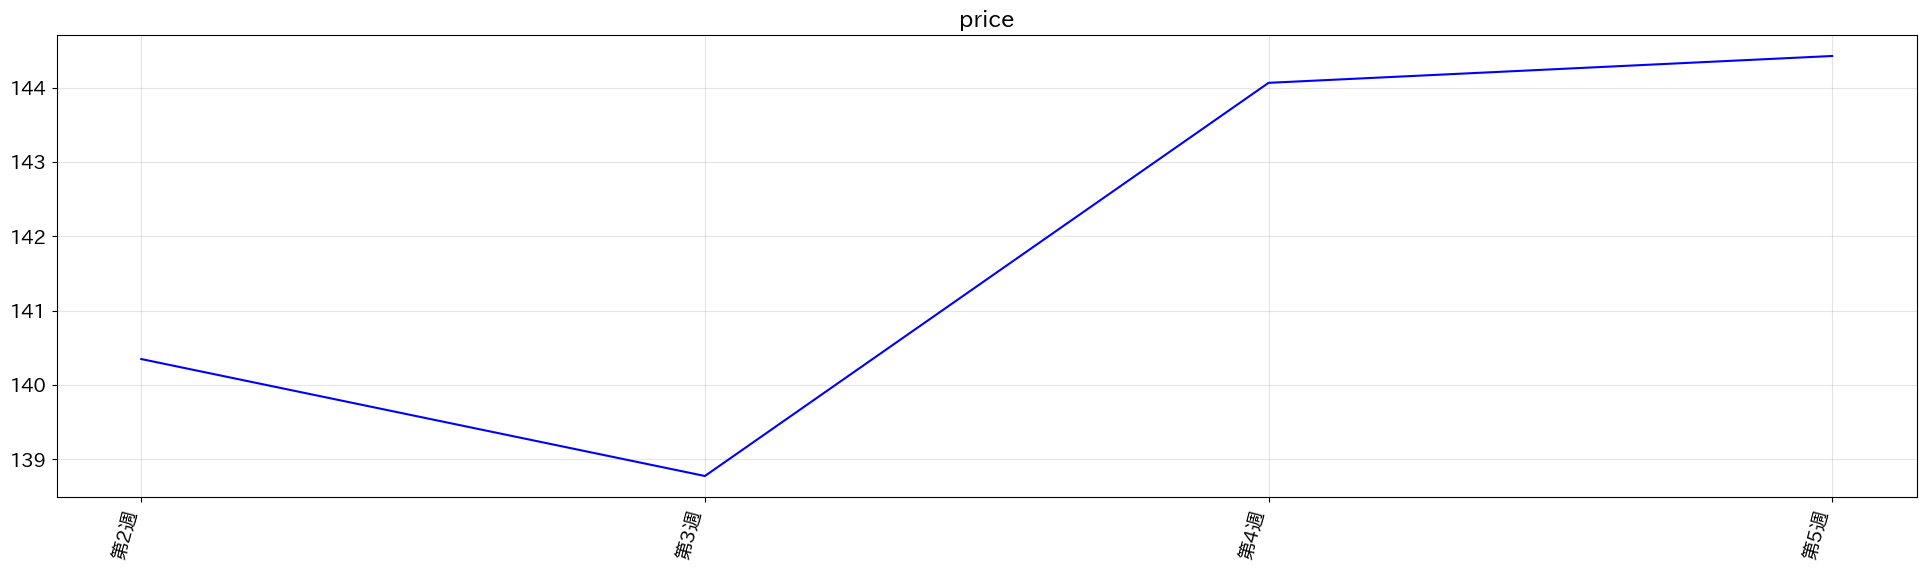

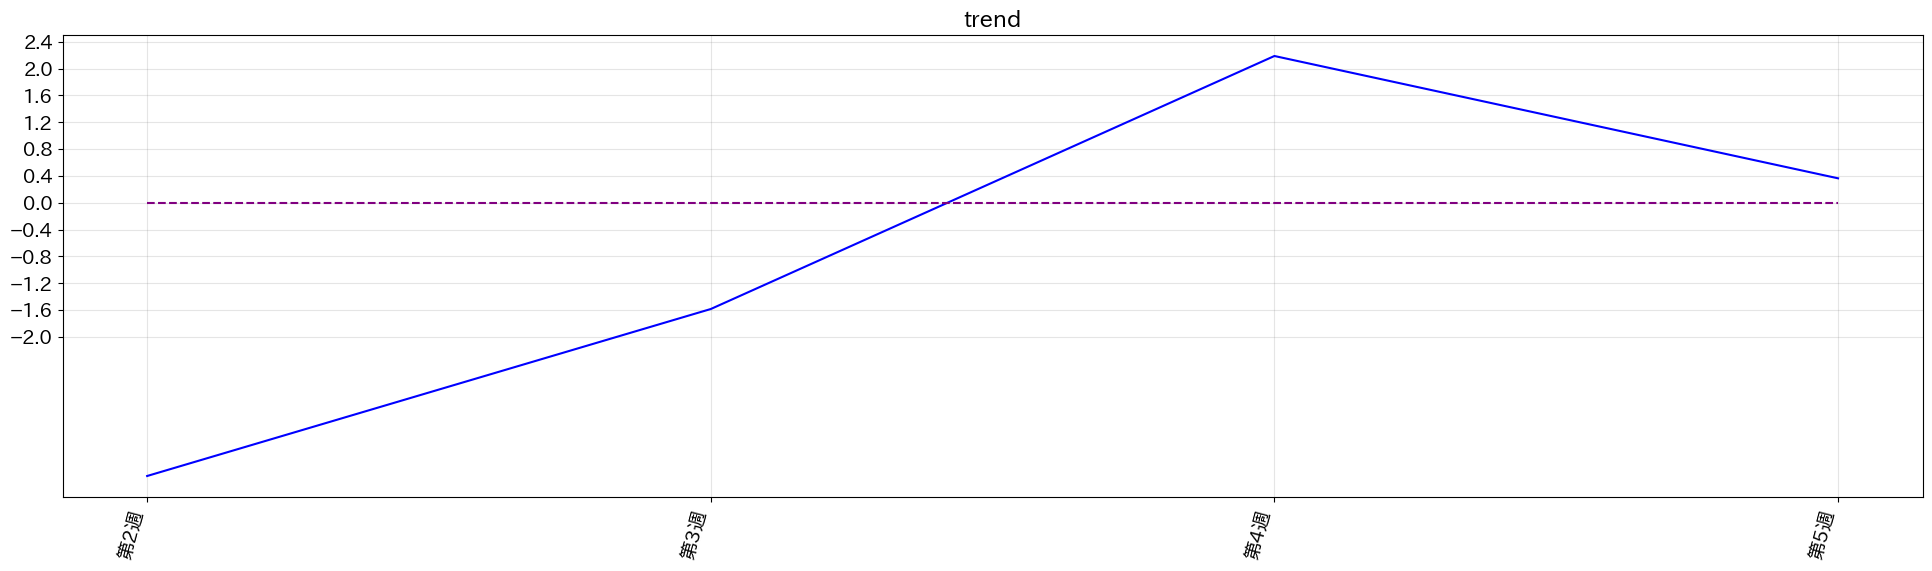

In [4]:
data = get_mt5_data(symbol, time_frame, data_back_pos, 5000)
periodicity_analysis_main_process(data)

### **<span style="color: purple; ">・BOT メインプログラム</span>**

●リアルタイム取得 元データ

,time,open,high,low,close,tick_volume,spread,real_volume
0,2022-11-14 00:10:00,139.39300,139.89900,139.39300,139.89900,228,58,0
1,2022-11-14 00:15:00,139.84800,139.85700,139.63300,139.68600,374,59,0
2,2022-11-14 00:20:00,139.67700,139.69500,139.67500,139.68600,61,121,0
3,2022-11-14 00:25:00,139.68600,139.77200,139.68600,139.75300,32,89,0
4,2022-11-14 00:30:00,139.76500,139.77400,139.70800,139.73600,52,61,0
...,...,...,...,...,...,...,...,...
49995,2023-07-14 23:35:00,138.80400,138.81900,138.80400,138.80400,10,23,0
49996,2023-07-14 23:40:00,138.80400,138.81400,138.79900,138.81100,67,25,0
49997,2023-07-14 23:45:00,138.81100,138.83500,138.80500,138.81400,166,21,0
49998,2023-07-14 23:50:00,138.81400,138.81400,138.78500,138.78500,92,22,0



●相関係数

,close,low,high,open,ema_6,ema_close_9,sma_7,hampel_Mid,lower_sigma_2_20,upper_sigma_2_20,lower_sigma_3_20,upper_sigma_3_20
close,1.000000,0.999947,0.999944,0.999898,0.999890,0.999812,0.999804,0.999222,0.998904,0.998519,0.998222,0.997625
low,0.999947,1.000000,0.999895,0.999936,0.999893,0.999817,0.999817,0.999222,0.999029,0.998395,0.998409,0.997438
high,0.999944,0.999895,1.000000,0.999942,0.999911,0.999845,0.999841,0.999287,0.998835,0.998709,0.998090,0.997880
open,0.999898,0.999936,0.999942,1.000000,0.999934,0.999874,0.999878,0.999321,0.998988,0.998622,0.998302,0.997733
ema_6,0.999890,0.999893,0.999911,0.999934,1.000000,0.999984,0.999983,0.999580,0.999192,0.998886,0.998491,0.998012
ema_close_9,0.999812,0.999817,0.999845,0.999874,0.999984,1.000000,0.999984,0.999720,0.999287,0.999039,0.998570,0.998180
sma_7,0.999804,0.999817,0.999841,0.999878,0.999983,0.999984,1.000000,0.999615,0.999215,0.998919,0.998511,0.998048
hampel_Mid,0.999222,0.999222,0.999287,0.999321,0.999580,0.999720,0.999615,1.000000,0.999328,0.999326,0.998551,0.998528
lower_sigma_2_20,0.998904,0.999029,0.998835,0.998988,0.999192,0.999287,0.999215,0.999328,1.000000,0.997476,0.999846,0.996043
upper_sigma_2_20,0.998519,0.998395,0.998709,0.998622,0.998886,0.999039,0.998919,0.999326,0.997476,1.000000,0.996076,0.999839



●load model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 5, 37)             5661      
                                                                 
 dropout (Dropout)           (None, 5, 37)             0         
                                                                 
 gru_7 (GRU)                 (None, 37)                8436      
                                                                 
 dropout_1 (Dropout)         (None, 37)                0         
                                                                 
 dense (Dense)               (None, 12)                456       
                                                                 
Total params: 14,553
Trainable params: 14,553
Non-trainable params: 0
_________________________________________________________________

・精度確認
・test  evaluate loss : 

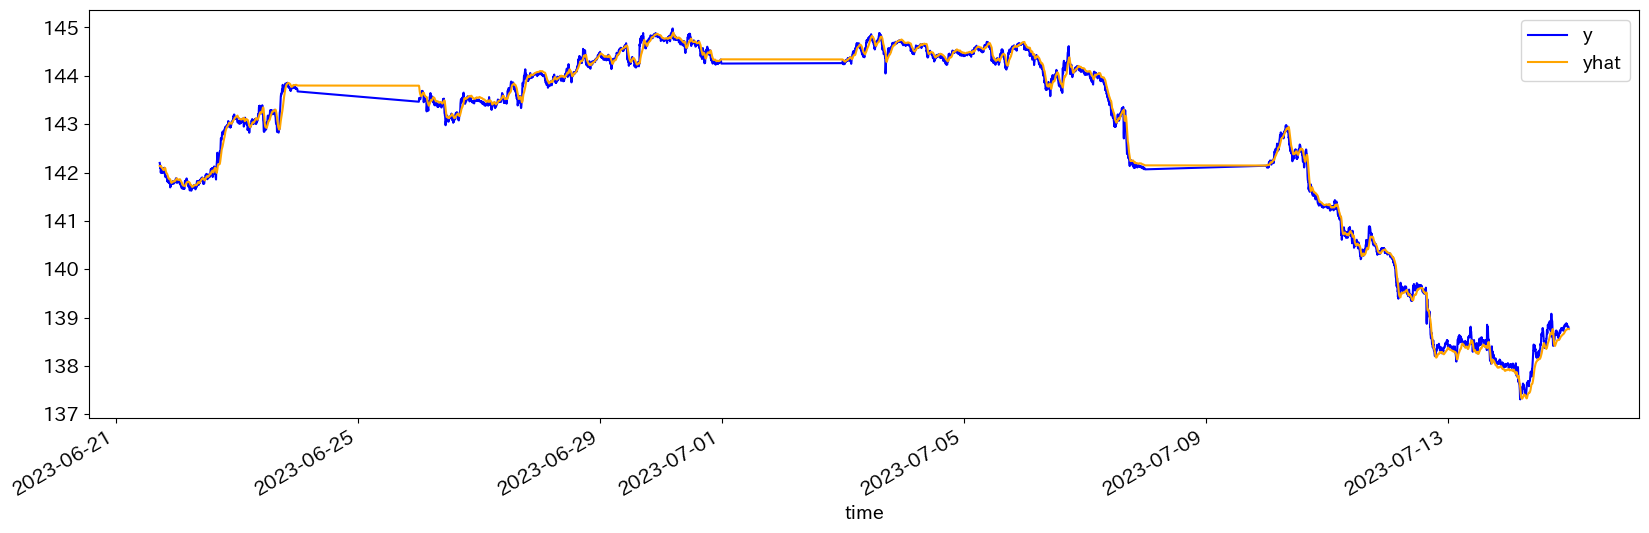

●2バー分 未来予測
・predict 結果


,y,yhat
0,138.02000,137.91721
1,138.02600,137.91408
2,138.04500,137.91380
3,138.03600,137.91557
4,138.02500,137.91969
...,...,...
295,138.81400,138.76770
296,138.78500,138.76555
297,138.77500,138.76515
298,NaN,138.72844



・精度確認
・mae: 0.1682, mape: 0.0012, mse: 0.0419, rmse: 0.2046, r2: 0.8068


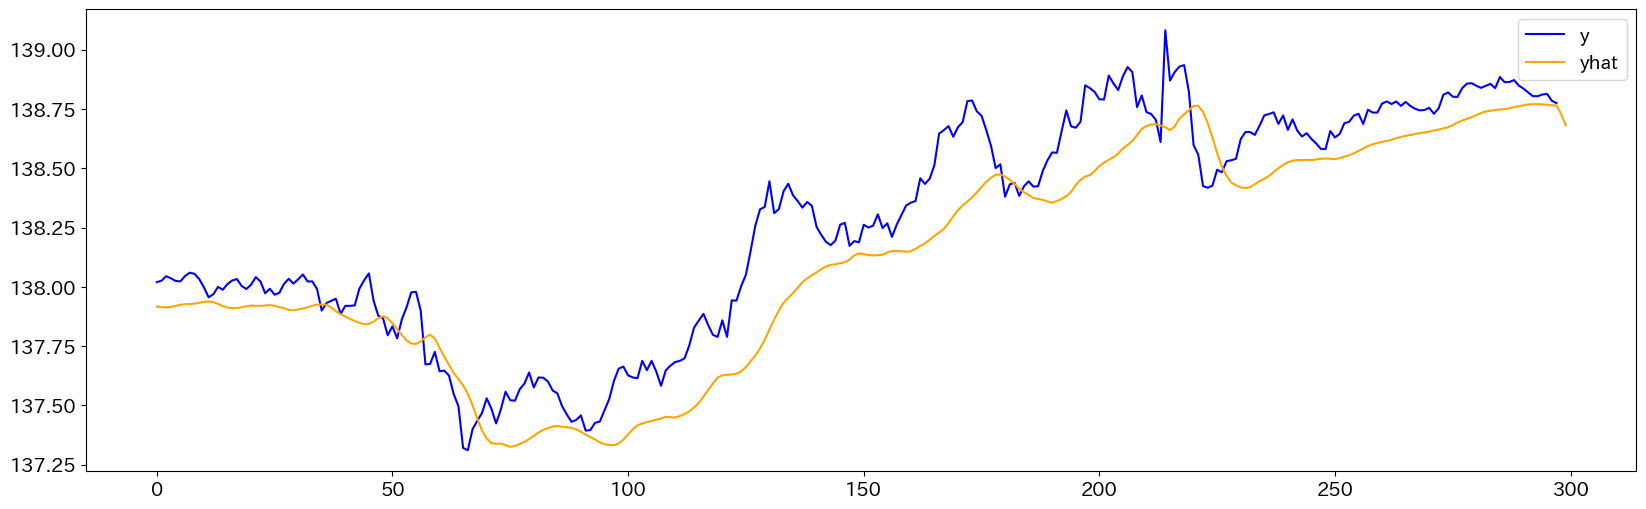

●2バー分 追加データ（インジケーター再計算使用）

,time,close,open,high,low
0,2023-07-13 23:10:00,138.02000,138.01000,138.02500,137.99700
1,2023-07-13 23:15:00,138.02600,138.02100,138.02600,138.01500
2,2023-07-13 23:20:00,138.04500,138.03400,138.04900,138.02800
3,2023-07-13 23:25:00,138.03600,138.04500,138.04500,138.03400
4,2023-07-13 23:30:00,138.02500,138.03500,138.03700,138.02300
...,...,...,...,...,...
295,2023-07-14 23:45:00,138.81400,138.81100,138.83500,138.80500
296,2023-07-14 23:50:00,138.78500,138.81400,138.81400,138.78500
297,2023-07-14 23:55:00,138.77500,138.78500,138.82000,138.77000
298,2023-07-15 00:00:00,138.72844,138.71227,138.69873,138.64928



●自動取引必要情報
・Balance                      : 85539.0
・margin_level                 : 0.0 %
・銘柄: USDJPY
・spread                       : 21

・bollinger_spread_range       : 0.098 / 0.05 / 0.6
・atr                          : 0.027 / 0.01
・trend_flag                   : 2023-07-14 23:55:00 / -0.0066 / 0
・trand_judgment_material_flag : False のためパス

●インジケーター再計算後 全データ

,time,close,open,high,low,tr_14,atr_14,ema_5,ema_10,sma_9,...,minus_di_50,ema_close_150,ema_high_150,ema_low_150,%D_7,sma_7,trend_clac_change_7_sma,ema_7,trend_clac_change_7_ema,trend_flag
0,2023-07-13 23:10:00,138.02000,138.01000,138.02500,137.99700,NaN,NaN,138.02000,138.02000,NaN,...,NaN,138.02000,138.02500,137.99700,NaN,NaN,NaN,138.02000,NaN,0
1,2023-07-13 23:15:00,138.02600,138.02100,138.02600,138.01500,0.01100,NaN,138.02200,138.02109,NaN,...,NaN,138.02008,138.02501,137.99724,NaN,NaN,NaN,138.02150,0.00109,0
2,2023-07-13 23:20:00,138.04500,138.03400,138.04900,138.02800,0.02300,NaN,138.02967,138.02544,NaN,...,NaN,138.02041,138.02533,137.99765,NaN,NaN,NaN,138.02738,0.00426,0
3,2023-07-13 23:25:00,138.03600,138.04500,138.04500,138.03400,0.01100,NaN,138.03178,138.02736,NaN,...,NaN,138.02062,138.02559,137.99813,NaN,NaN,NaN,138.02953,0.00156,0
4,2023-07-13 23:30:00,138.02500,138.03500,138.03700,138.02300,0.01400,NaN,138.02952,138.02693,NaN,...,NaN,138.02067,138.02574,137.99846,NaN,NaN,NaN,138.02840,-0.00082,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2023-07-14 23:45:00,138.81400,138.81100,138.83500,138.80500,0.03000,0.02407,138.81621,138.82500,138.83044,...,97.80030,138.60712,138.63626,138.57511,55.03944,138.81971,-0.00597,138.82055,-0.00157,0
296,2023-07-14 23:50:00,138.78500,138.81400,138.81400,138.78500,0.02900,0.02521,138.80581,138.81773,138.82167,...,100.52063,138.60948,138.63862,138.57789,49.43032,138.81057,-0.00659,138.81166,-0.00640,0
297,2023-07-14 23:55:00,138.77500,138.78500,138.82000,138.77000,0.05000,0.02700,138.79554,138.80996,138.81089,...,101.46103,138.61167,138.64102,138.58043,44.08414,138.80186,-0.00628,138.80250,-0.00660,0
298,2023-07-15 00:00:00,138.72844,138.71227,138.69873,138.64928,0.12572,0.03434,138.77317,138.79514,138.79749,...,119.06754,138.61322,138.64178,138.58134,40.83639,138.78878,-0.00942,138.78398,-0.01334,0




●各種指標グラフ

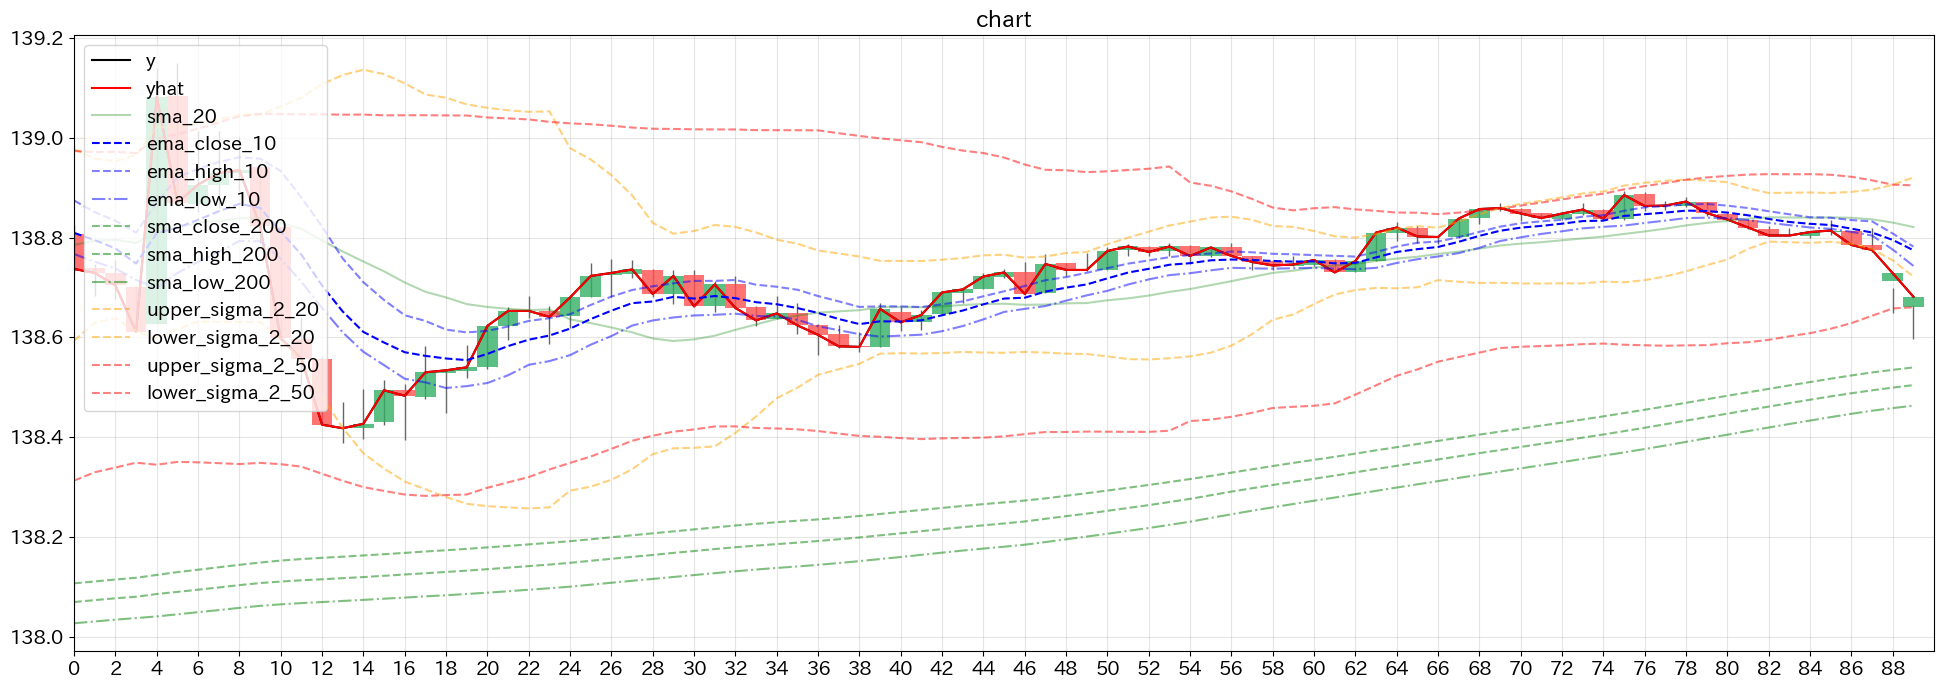

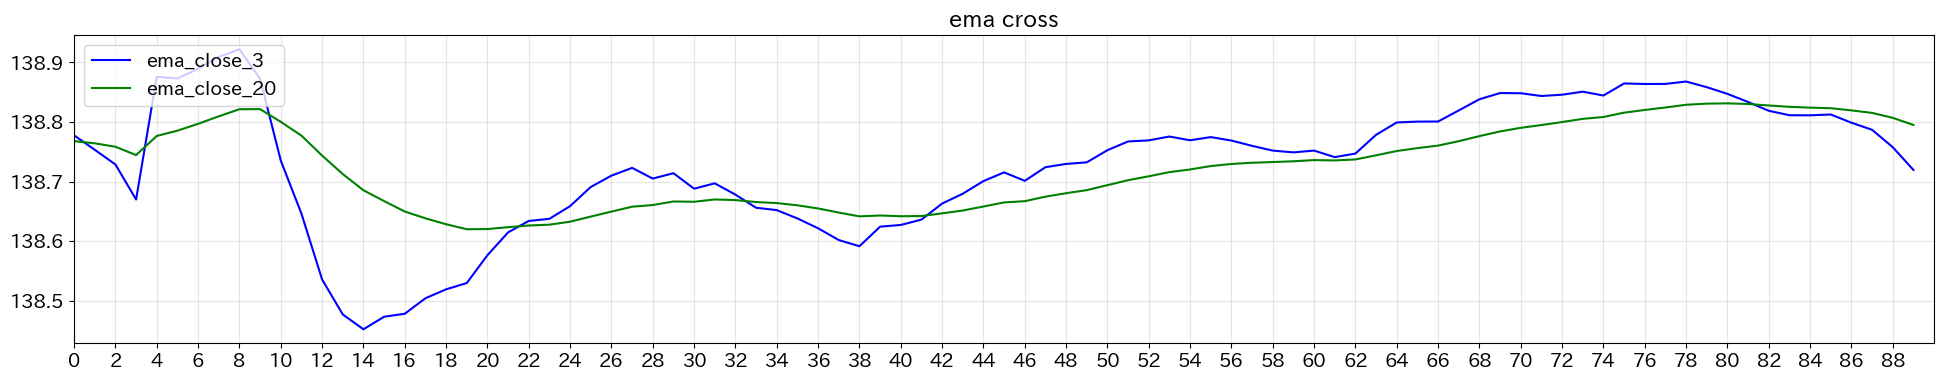

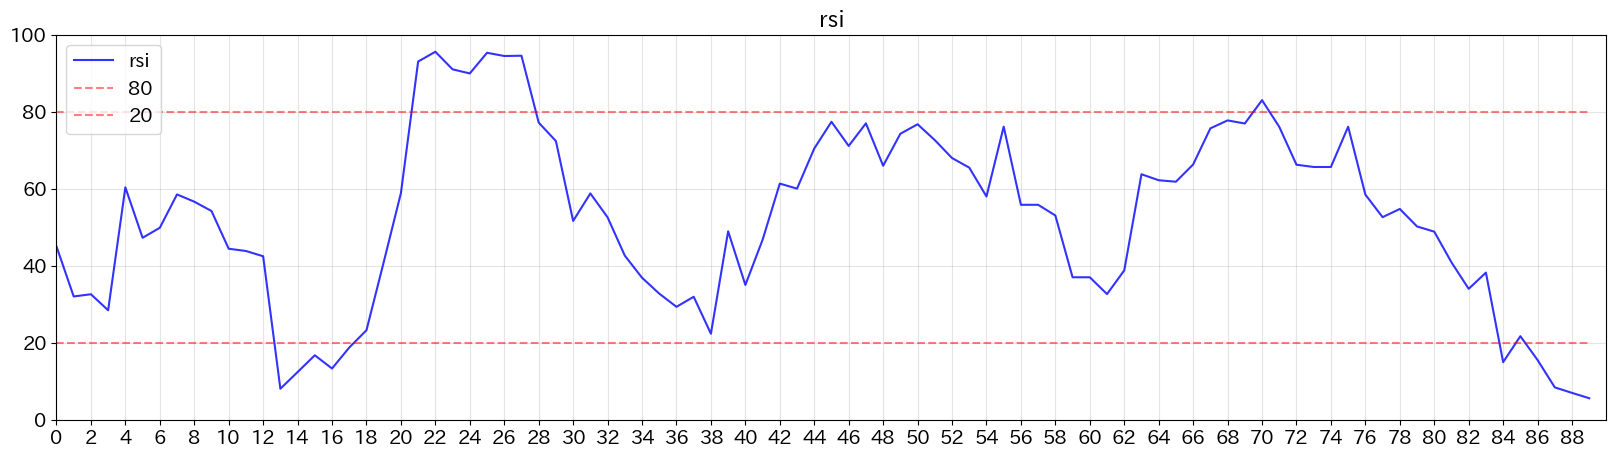

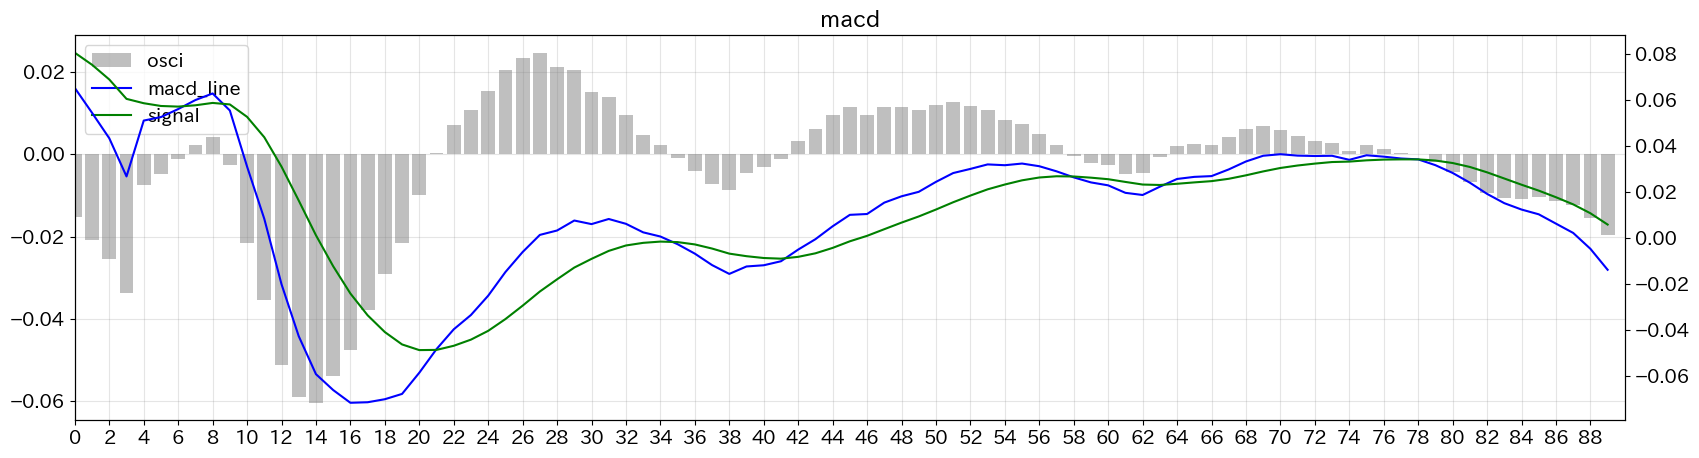

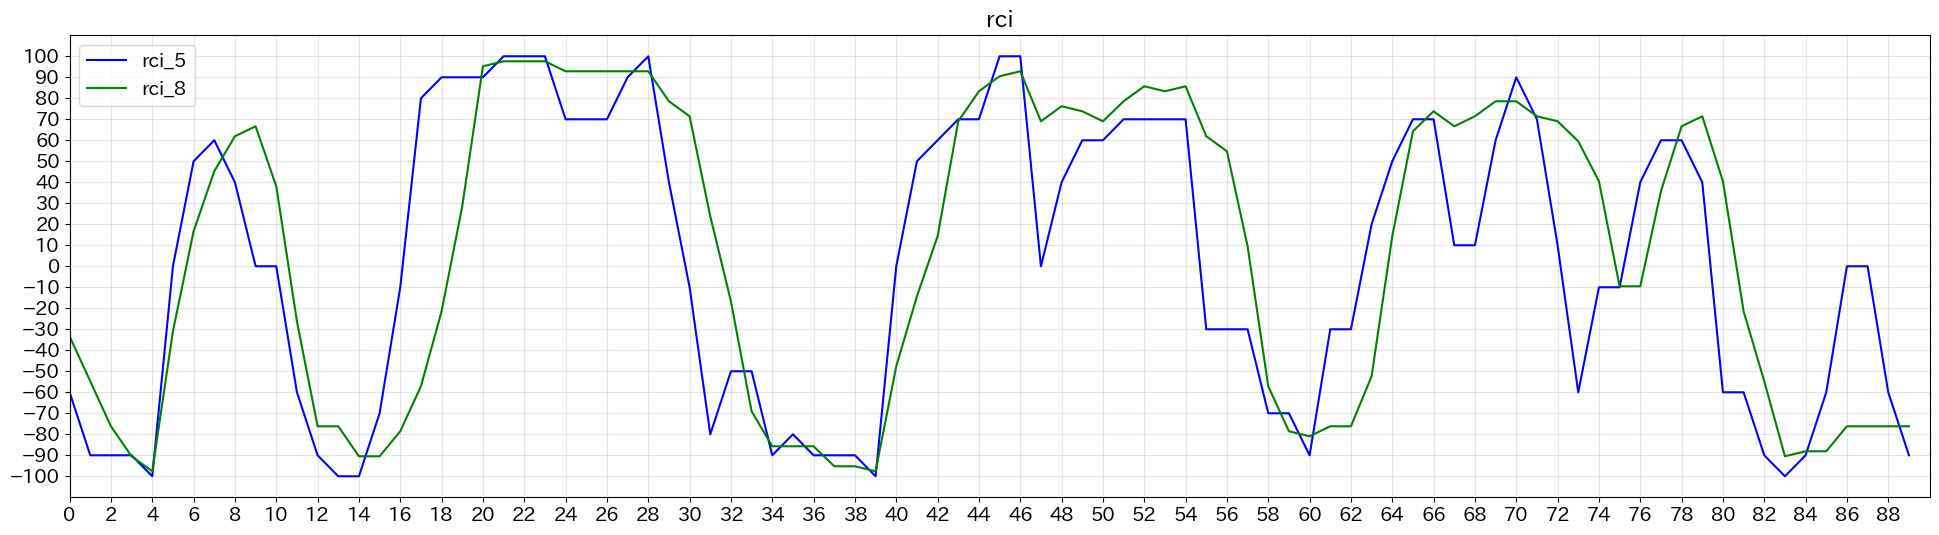

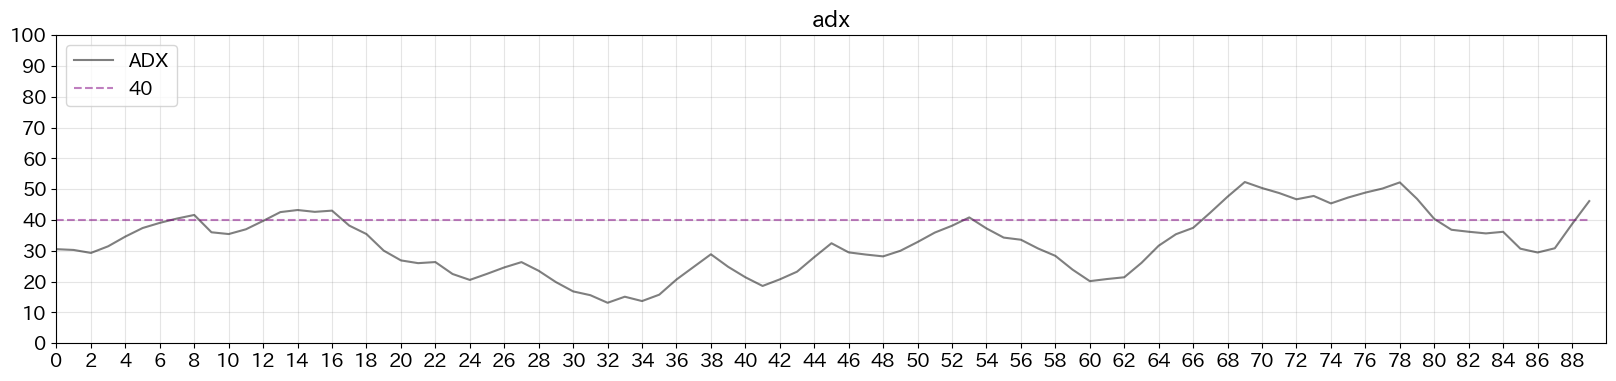

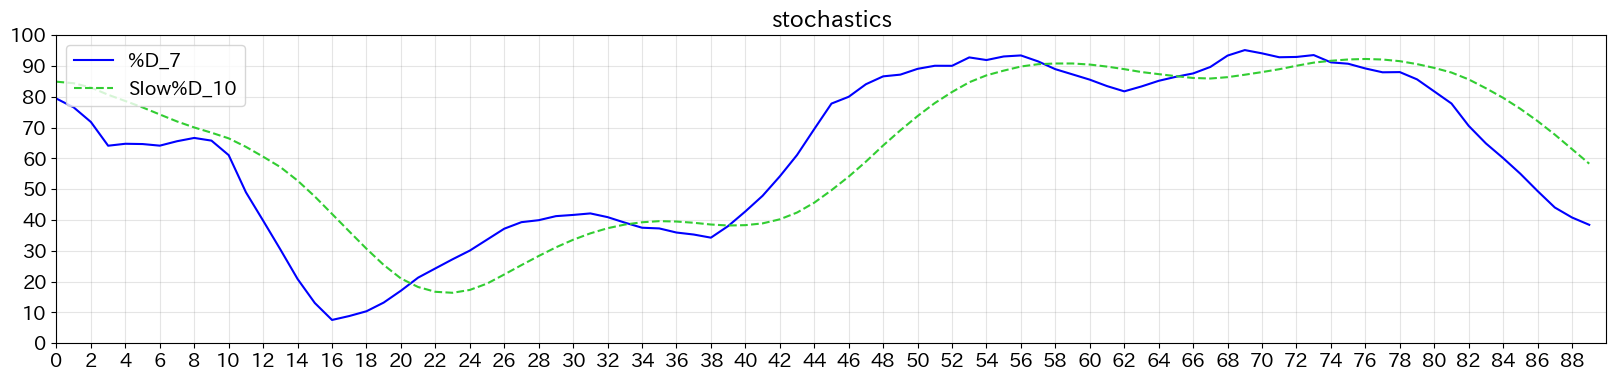

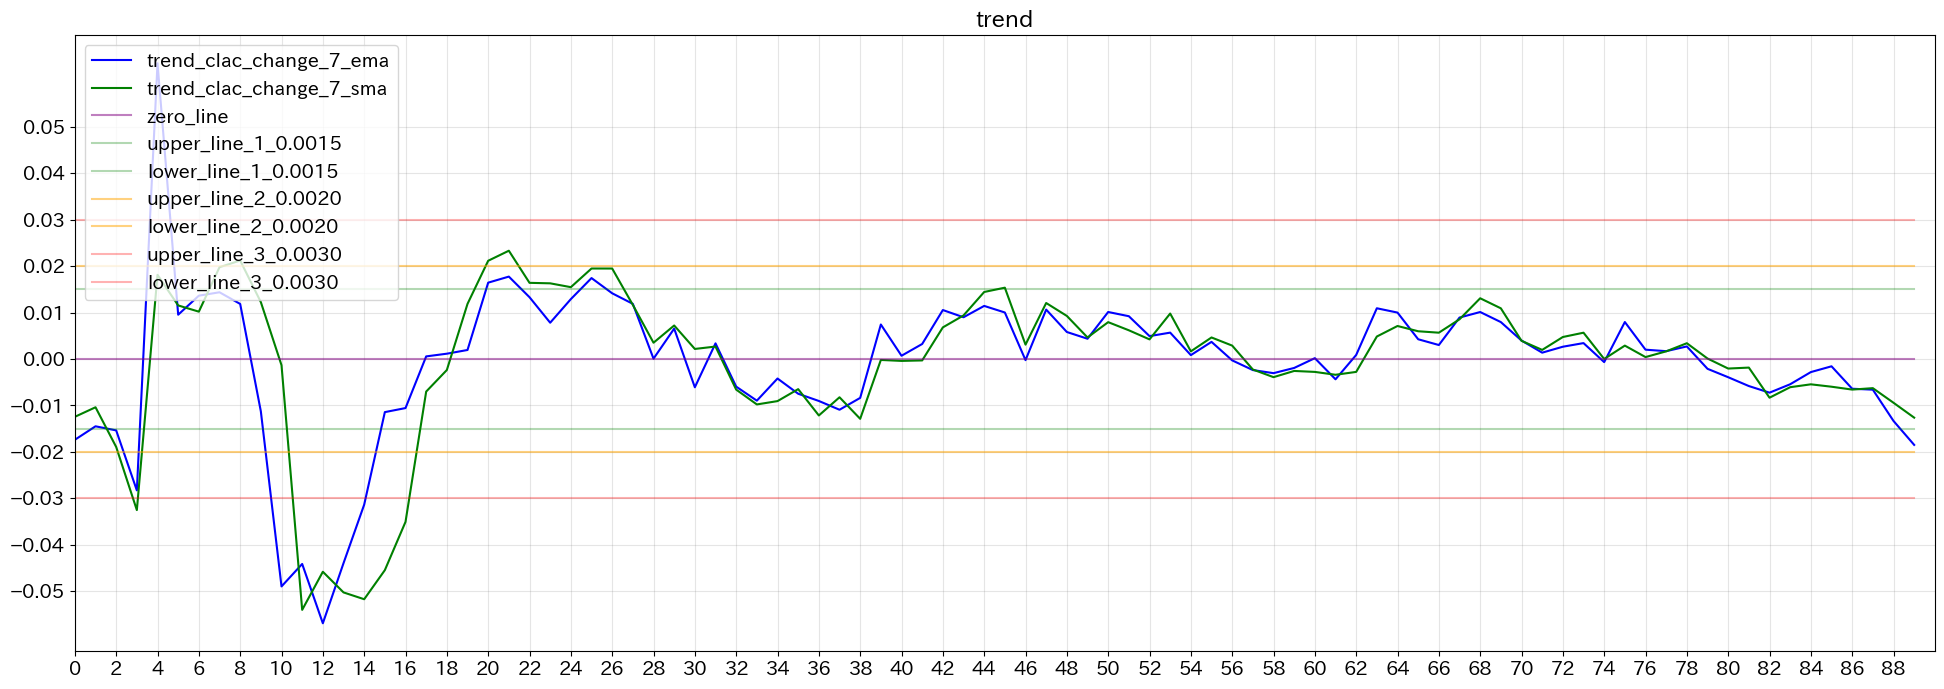

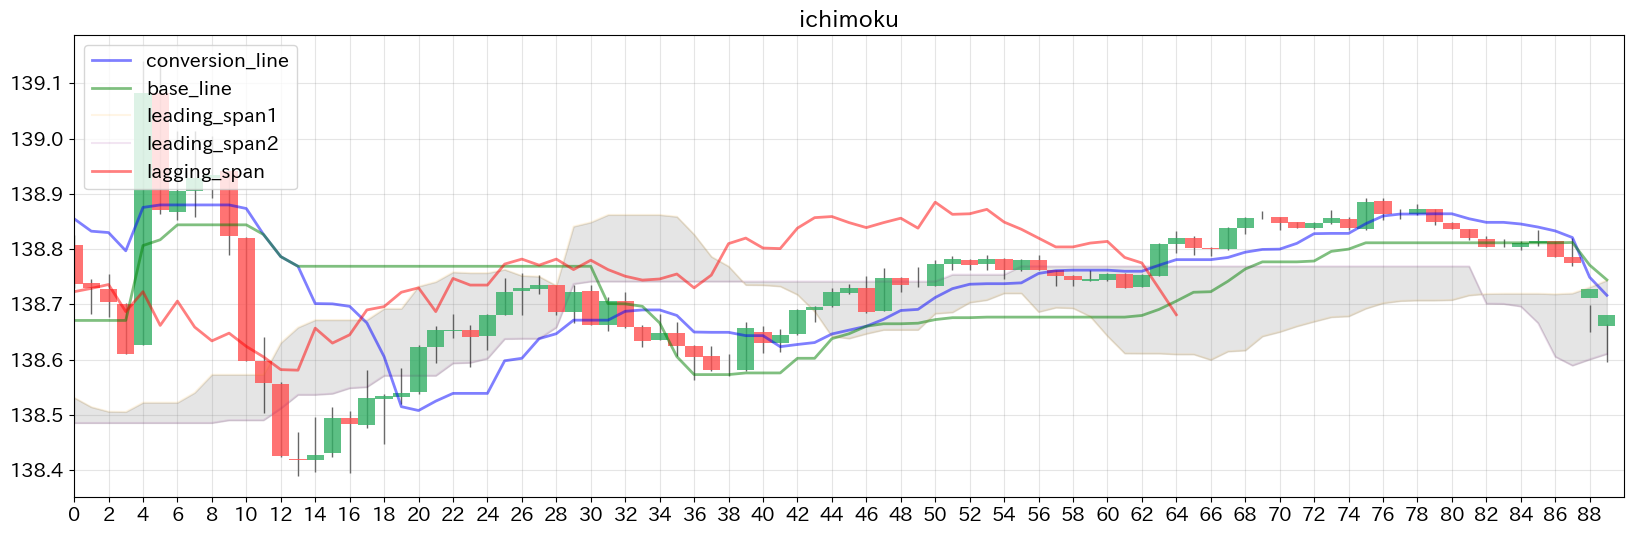

In [5]:

hparams = {
  'use_model': "gru",
  'epochs': 300,
  'batch_size': 128,
  'layer_num': 2,
  'units': 37,
  'activation': 'Mish',
  'batch_normalization_use': False,
  'dropout_rate': 0.014928612680913257,
  'optimizer': Adam(learning_rate=0.014928612680913257),
  'loss': 'mse',
  'min_delta': 1e-08,
  'restore_best_weights': True,
}   

####################################################################################################

cnt = 0
while True:
    #-- 指定時間外は取引を中断
    if (trade_start_time_tk <= datetime.now() < trade_end_time_tk) or (trade_start_time_ny <= datetime.now() < trade_end_time_ny):

        while True:
            position_list = get_all_positions(symbol_list)

            if len(position_list) == 0:
                if (trade_end_time_tk <= datetime.now()) or (trade_end_time_ny <= datetime.now()):
                    print(f'・予定取引時間を超過したため終了')
                    break
                            
            #-- 口座情報を取得する
            account_info = mt5.account_info()
            if account_info is None:
                print(f"Retreiving account information failed")
            else:
                account_balance = np.round(account_info.balance, decimals=2)
                account_margin_level = np.round(account_info.margin_level, decimals=2)

            if True:
                calculate_use_dic = calculate_use_num(symbol_list, time_frame, data_back_pos, calc_use_num)        

                for symbol in symbol_list:
                    try:
                        period_adj = -future_period-1                
                        val_set_dic = val_set_def()

                        data = get_mt5_data(symbol, time_frame, data_back_pos, bar_period)
                        print("●"+BLUE_BOLD+"リアルタイム取得 元データ"+END, end="")                    
                        display(data)
                        spread = data.iloc[period_adj]["spread"]
                                
                        #-- spread許容値内外で分岐
                        if (trade_mode == 0) or (trade_mode == 1):
                            if spread > spread_tolerance:
                                print(f'・spread: {spread} 規定値以上のためパス')
                                continue

                                
                        flag_calc_data = use_data_create(data, val_set_dic)                        
                                              
                        #-- モデル使用用のデータを作成
                        pred_use_data, use_variable_check_df, delete_cols_dic, train_x, train_y, valid_x, valid_y, test_x, test_y, input_shape, output_shape, sc, df, col_name_list = \
                        create_pred_data(
                          flag_calc_data, rnn_batch_size, train_rate, test_rate, variable_delete_rate_min, variable_delete_rate_max, outlier_handling_use, multiplier,
                          select_mode=select_mode, dim_quantity=dim_quantity, reverse=True
                        )                

                        print("\n●"+BLUE_BOLD+"相関係数"+END, end="")
                        display(use_variable_check_df.corr().style.background_gradient())

                        #-- model loadしない場合
#                        best_prams, best_score, best_model_number, sorted_dic = json_params_loader(
#                            "optuna_202306151159_usdjpy_gru_x4_49955_complete_normal", load_mode = 1, select_score="r2_calc")
#                        display(best_prams)
#                        display(best_score)
                        
#                        create_rnn_model = CreateRnnModel(**hparams)
#                        model, history = create_rnn_model\
#                          .rnn_main_process(input_shape, output_shape, train_x, train_y, validation_data=(valid_x, valid_y))                

#                        use_params = create_rnn_model.get_params()
#                        display(use_params)
            
#                        rnn_result_display(
#                          model, train_x, train_y, valid_x, valid_y, test_x, test_y, 
#                          sc, df, col_name_list, batch_size=best_prams["batch_size"]
#                          , history=history
#                        )


                        #-- モデル読み込み
                        model_add_info = "_20230714_gru_Mish_b128_r2_9970_m5_x12_1"
                        reset_mish()
                        model = create_model_save_and_load(target_model_path, mode="load", model_add_info=model_add_info)    
                        print("\n●"+BLUE_BOLD+"load model summary"+END+"\n")
                        model.summary()                                                

                        load_model_score_check(                            
                            model, test_x, test_y, sc, df, col_name_list, render_graph=True,
                            test_mode=0,
                            batch_size=128
                        )

                        print("●"+BLUE_BOLD+"2バー分 未来予測"+END, end="")

                        future_pred_df = future_predict_on_test(
                          model, test_x, test_y, sc, df, col_name_list,
                          future_period=future_period, freq_num=freq_num, freq=freq, 
                          batch_size=1, render_graph=True
                        )
                        
                        future_pred_df = future_pred_df[-300:]
                        future_pred_df.reset_index(drop=True, inplace=True)
                        print("●"+BLUE_BOLD+"2バー分 追加データ（インジケーター再計算使用）"+END, end="")
                        display(future_pred_df)
                        
                        print("\n●"+BLUE_BOLD+"自動取引必要情報"+END)
                        show_info_outer(cnt, account_balance, account_margin_level, symbol, spread, flag_calc_data)        
                                            
                        while True:
                            #-- 本当はbreak用のif文がありましたが今回は削除しました。
                            
                            data = get_mt5_data(symbol, time_frame, data_back_pos, bar_period)
                            flag_calc_data = use_data_create(future_pred_df, val_set_dic)                
                            current_row = data["time"].max()        
                        

                            #-- 注文取消し 設定時刻を取得                
                            expiration_time = order_cancel(symbol, order_cancel_period=order_cancel_period)                        
                            point = mt5.symbol_info(symbol).point # 価格の最小単位
                            symbol_tick = mt5.symbol_info_tick(symbol) # symbolのtick情報を取得                        
                    
                            #-- 現在の時刻取得用
                            current_time = get_current_time()
                            use_trade_adj_time = current_time + timedelta(seconds=trade_wait_time)
                            use_graph_adj_time = current_time + timedelta(minutes=graph_wait_time)
                                         
                            #-- 戦略部分
                            buy_flg, sell_flg, buy_flag_type, sell_flag_type, bollinger_spread_range, trand_judgment_material_flag, \
                            atr_under_line, high_under_line, low_under_line, buy_flag_status, sell_flag_status, return_cross_flag, set_margin_level = \
                                generate_trade_flgs(
                                    flag_calc_data, symbol_tick, symbol, period_adj, spread, trade_mode, val_set_dic,
                                    f2_group, f3_group, f5_group, calculate_use_dic, cross_flag, set_margin_level
                                )

                            if last_trade_time.minute != datetime.now().minute:
                                result = position_close_order(symbol, magic_number, flag_calc_data, period_adj, trand_judgment_material_flag, val_set_dic)                            

                            if trand_judgment_material_flag == "range_trand_market" or trand_judgment_material_flag == "trand_market":
                                change_processing(symbol, point, magic_number) # 非公開ファイルの中身
                                    
                            cross_flag = return_cross_flag
                            bollinger_spread_range = np.round(bollinger_spread_range, decimals=5)
                            atr = flag_calc_data['atr_14'].iloc[period_adj]   
                            atr = np.round(atr, decimals=5)                
                            price_range_storage[symbol]["bollinger_spread_range"].append(bollinger_spread_range)
                            price_range_storage[symbol]["low_under_line"] = low_under_line
                            price_range_storage[symbol]["high_under_line"] = high_under_line              
                            price_range_storage[symbol]["atr"].append(atr)
                            price_range_storage[symbol]["atr_under_line"] = atr_under_line

        
                            account_margin_level = np.round(mt5.account_info().margin_level, decimals=2)
                        
                            show_info_inner(flag_calc_data, symbol, current_time, last_trade_time, last_graph_render_time_dic, bollinger_spread_range, low_under_line, high_under_line, atr, atr_under_line, trand_judgment_material_flag, buy_flag_type, sell_flag_type, account_margin_level, period_adj)
                    
                            print("\n●"+BLUE_BOLD+"インジケーター再計算後 全データ"+END, end="")
                            display(flag_calc_data)            
                    
    
                            if (last_graph_render_time_dic[symbol] < current_time):            
                                print("\n\n●"+BLUE_BOLD+"各種指標グラフ"+END, end="")
                                graph_render_main_process(flag_calc_data, val_set_dic, act_data=future_pred_df, graph_time_range=graph_time_range, graph_set_time_start=graph_set_time_start, graph_set_time_end=graph_set_time_end)

                                last_graph_render_time_dic[symbol] = use_graph_adj_time                                 

                
                            if trand_judgment_material_flag != False:                    
                                print(f'・trand_judgment_material_flag : {trand_judgment_material_flag}')        
                            elif trand_judgment_material_flag == False:                    
                                sleep(1)        
                                continue

                            #-- 非公開ファイルの中身。order、price関連の値をreturnする
                            buy_price_limit, buy_price_stop , sell_price_limit, sell_price_stop, tp, sl, tp_factor, sl_factor = process_use_settings(
                              symbol, trade_mode, flag_calc_data, atr=atr, point=point, symbol_tick=symbol_tick, spread=spread,
                              buy_flg=buy_flg, sell_flg=sell_flg, trand_judgment_material_flag=trand_judgment_material_flag, period_adj=period_adj,
                              f2_group=f2_group, f3_group=f3_group, f5_group=f5_group, buy_flag_status=buy_flag_status, sell_flag_status=sell_flag_status,
                              setting_mode=1
                            )

                            
                            if 0.0 < account_margin_level < set_margin_level:
                                print("・証拠金維持率不足。取引に余裕を持たせるためパス")
                                pass
                            else:                                
                                if trade_stop_flag == 1:
                                    pass                        
                                elif last_trade_time < current_time:
                                    #-- 注文を実行
                                    result = \
                                    order_send(
                                        symbol, buy_flg, sell_flg, first_lot, buy_price_stop, buy_price_limit, sell_price_stop, sell_price_limit,
                                        sl, tp, slippage, magic_number, expiration_time, trand_judgment_material_flag
                                    )   
                                
                                    display(result)
                                    if buy_flg or sell_flg:
                                        last_trade_time = use_trade_adj_time
            
                            sleep(1)        
                    except:    
                        error_mes = traceback.format_exc()
                        print(error_mes + "\n")

            #-- cntはデバッグ用の物
            cnt += 1
            if cnt == 1:
                break
    
    else:
        print(f'・取引予定時間外')
    sleep(60)


### **<span style="color: purple; ">・optuna作成 model、hparams（mseソート）</span>**

In [6]:
#-- optunaで作成した1000個分のモデル関連データ

params_score_sorted_dic, score_sorted_list = json_params_loader(
    "optuna_202306151159_usdjpy_gru_x4_49955_complete_normal", load_mode = 2, select_score="mse_calc")
display(params_score_sorted_dic)
display(score_sorted_list)

{'gru_236': {'score': {'mae_calc': 0.0028060638155930078,
   'mape_calc': 0.0033862672159129404,
   'mse_calc': 1.809965946687351e-05,
   'rmse_calc': 0.00425436945585048,
   'r2_calc': 0.9881331146865419},
  'params': {'rnn_batch_size': 5,
   'epochs': 300,
   'batch_size': 128,
   'layer_num': 2,
   'units': 37,
   'activation': None,
   'batch_normalization': False,
   'dropout_rate': 0.014928612680913257,
   'lr': 5.166511704901831e-05,
   'min_delta': 1e-08,
   'restore_best_weights': True,
   'early_stopping': 0}},
 'gru_916': {'score': {'mae_calc': 0.002796872258146389,
   'mape_calc': 0.0033727399464809705,
   'mse_calc': 1.8763442979701216e-05,
   'rmse_calc': 0.004331679002384781,
   'r2_calc': 0.987696627916955},
  'params': {'rnn_batch_size': 5,
   'epochs': 300,
   'batch_size': 128,
   'layer_num': 2,
   'units': 26,
   'activation': None,
   'batch_normalization': False,
   'dropout_rate': 0.006570143195918887,
   'lr': 8.614429071448148e-05,
   'min_delta': 1e-08,
   'r

['gru_236',
 'gru_916',
 'gru_475',
 'gru_99',
 'gru_110',
 'gru_194',
 'gru_14',
 'gru_758',
 'gru_901',
 'gru_197',
 'gru_597',
 'gru_3',
 'gru_568',
 'gru_348',
 'gru_104',
 'gru_468',
 'gru_588',
 'gru_228',
 'gru_288',
 'gru_802',
 'gru_690',
 'gru_722',
 'gru_513',
 'gru_787',
 'gru_169',
 'gru_192',
 'gru_256',
 'gru_882',
 'gru_318',
 'gru_246',
 'gru_785',
 'gru_648',
 'gru_286',
 'gru_633',
 'gru_950',
 'gru_632',
 'gru_694',
 'gru_386',
 'gru_365',
 'gru_798',
 'gru_7',
 'gru_367',
 'gru_81',
 'gru_604',
 'gru_218',
 'gru_206',
 'gru_822',
 'gru_205',
 'gru_116',
 'gru_164',
 'gru_451',
 'gru_63',
 'gru_677',
 'gru_922',
 'gru_680',
 'gru_591',
 'gru_577',
 'gru_708',
 'gru_37',
 'gru_41',
 'gru_849',
 'gru_554',
 'gru_100',
 'gru_165',
 'gru_171',
 'gru_28',
 'gru_293',
 'gru_336',
 'gru_616',
 'gru_480',
 'gru_296',
 'gru_273',
 'gru_245',
 'gru_105',
 'gru_625',
 'gru_64',
 'gru_949',
 'gru_801',
 'gru_352',
 'gru_380',
 'gru_138',
 'gru_977',
 'gru_443',
 'gru_924',
 'gr